In [1]:
import torch
import e3nn
from torch.utils.cpp_extension import load
import json
import matplotlib.pyplot as plt
import itertools
import os
import cuequivariance as cue
import cuequivariance_torch as cuet
import random
from typing import List
from torchviz import make_dot

In [2]:
os.environ['TORCH_CUDA_ARCH_LIST'] = "8.0"
sptp_bwd_bwd = load(name='sptp_linear_bwd_bwd', sources=['/home2/lsy/mdsim/fused_e3nn/fused_e3nn_kernel/sptp_linear_bwd_bwd.cpp', 
                                  '/home2/lsy/mdsim/fused_e3nn/fused_e3nn_kernel/bwd_bwd_sptp_linear_v2_shared.cu',
                                  ], 
                                  extra_cuda_cflags=["-lineinfo"], verbose=True)


Using /home2/lsy/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home2/lsy/.cache/torch_extensions/py311_cu124/sptp_linear_bwd_bwd/build.ninja...
Building extension module sptp_linear_bwd_bwd...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module sptp_linear_bwd_bwd...


In [3]:
def mul_Irreps(mul, i_in):
    dd = []
    for ori_mul, ir in i_in:
        dd.append((ori_mul*mul, (ir.l, ir.p)))
    return e3nn.o3.Irreps(dd)
def compare(a, b):
    isclose = torch.isclose(a, b)
    diff_pos = torch.argwhere(isclose == False)
    anything_bad = False
    for pos in diff_pos:
        pos_t = [x for x in pos]
        if(abs(a[pos_t] - b[pos_t]) > 1e-6):
            anything_bad = True
            print(pos)
            print(a[pos_t] - b[pos_t] )
    if(not anything_bad):
        print("All Good")
            
IR_IN1_IDX = 0
IR_IN2_IDX = 1
IR_OUT_IDX = 2
INST_IDX = 3

def load_nequip_config(h, l_max, layer_idx):
    filename = f"/home2/lsy/mdsim/nequip/benchmark_config/4_{h}_{l_max}_p_sc.txt"
    with open(filename, "r") as f:
        f_in = f.read().split("\n")

    per_layer_dict = dict()
    for l_idx, d in enumerate(f_in):
        if(d == "") : continue
        dd = json.loads(d)
        per_layer_dict[l_idx] = dd
    tp_list = per_layer_dict[layer_idx]["tp"]
    i_in1 = e3nn.o3.Irreps(tp_list[IR_IN1_IDX])
    i_in2 = e3nn.o3.Irreps(tp_list[IR_IN2_IDX])
    i_out = e3nn.o3.Irreps(tp_list[IR_OUT_IDX])
    inst_tuple = [tuple(x) for x in tp_list[INST_IDX]]

    return i_in1, i_in2, i_out, inst_tuple


In [4]:
def load_nequip_config_e3nn_cueq(h, l_max, layer_idx):
    filename = f"/home2/lsy/mdsim/nequip/benchmark_config/4_{h}_{l_max}_p_sc.txt"
    with open(filename, "r") as f:
        f_in = f.read().split("\n")

    per_layer_dict = dict()
    for l_idx, d in enumerate(f_in):
        if(d == "") : continue
        dd = json.loads(d)
        per_layer_dict[l_idx] = dd
    tp_list = per_layer_dict[layer_idx]["tp"]

    ei_in1 = e3nn.o3.Irreps(tp_list[IR_IN1_IDX])
    ei_in2 = e3nn.o3.Irreps(tp_list[IR_IN2_IDX])
    ei_out = e3nn.o3.Irreps(tp_list[IR_OUT_IDX])
    inst_tuple = [tuple(x) for x in tp_list[INST_IDX]]


    # changing mul for each ir.l
    new_in1_list = []
    new_out_list = []
    changed_idx = [[],[]]
    # mul_list = {}
    mul_list = {0:64, 1:32}

    for idx, (mul,ir) in enumerate(ei_in1):
        if (ir.l in mul_list):
            new_in1_list.append((mul_list[ir.l], ir))
            for inst in inst_tuple:
                if(idx == inst[0]):
                    changed_idx[0].append(inst[2])
                    changed_idx[1].append(mul_list[ir.l])
        else:
            new_in1_list.append((mul, ir))

    for idx, (mul,ir) in enumerate(ei_out):
        if (idx in changed_idx[0]):
            new_out_list.append((changed_idx[1][changed_idx[0].index(idx)], ir))
        else:
            new_out_list.append((mul, ir))

    ei_in1 = e3nn.o3.Irreps(new_in1_list)
    ei_out = e3nn.o3.Irreps(new_out_list)

    ci_in1 = cue.Irreps("O3", str(ei_in1))
    ci_in2 = cue.Irreps("O3", tp_list[IR_IN2_IDX])
    ci_out = cue.Irreps("O3", str(ei_out))


    return [ei_in1,ei_in2,ei_out,inst_tuple] , [ci_in1,ci_in2,ci_out,inst_tuple]


In [5]:
def to_cuda_list(*arg, input_dtype = torch.float32):
    return_list = []
    for item in arg:
        if(type(item) == torch.Tensor):
            return_list.append(item.to(device="cuda"))
        else:
            return_list.append(torch.tensor(item,device="cuda", dtype=input_dtype))
    return return_list

def to_cuda_dict(strname_list, *arg):
    return_dict = {}
    for item,name in zip(arg,strname_list):
        if(type(item) == torch.Tensor):
            return_dict[name] = item.to("cuda")
        else:
            return_dict[name] = torch.tensor(item,device="cuda")
    return return_dict

def cumsum_list(s, np1 = True):
    new_s = []
    current = 0
    for e in s:
        new_s.append(current)
        current += e
    if(np1):
        new_s.append(current)
    return new_s

In [6]:
torch.manual_seed(0)

h = 32
l_max = 1
layer_idx = 3
batch_size = 4096
# i_in1, i_in2, i_out, inst_tuple = load_nequip_config(h,l_max,layer_idx)
# i_in2 = mul_Irreps(3, i_in2)
e3nn_config, cueq_config = load_nequip_config_e3nn_cueq(h,l_max,layer_idx)
i_in1, i_in2, i_out, inst_tuple = e3nn_config

# not really needed for v=1 
uvuv_tp = e3nn.o3.FullTensorProduct(i_in1,i_in2, filter_ir_out=i_out)
uvuv_i_out = uvuv_tp.irreps_out

# split_size = []
# reshape_size = []
# for inst in uvuv_tp.instructions:
#     split_size.append(uvuv_i_out[inst.i_out].dim)
#     reshape_size.append([inst.path_shape[0],inst.path_shape[1],uvuv_i_out[inst.i_out][1].dim])
# weight_mul = e3nn.o3.experimental.FullTensorProduct_uvu_weight_only(i_in1, i_in2, split_size, reshape_size, filter_ir_out=i_out, irrep_normalization=None, regroup_output=False)
# uvw
# i_out = e3nn.o3.Irreps(tp_list[IR_OUT_IDX])
# tp = e3nn.o3.FullyConnectedTensorProduct(i_in1,i_in2,i_out,shared_weights=False, internal_weights=False)

# # uvu
tp = e3nn.o3.TensorProduct(i_in1,i_in2,i_out,inst_tuple,shared_weights=False, internal_weights=False,)#path_normalization="none", normalization="none")

/home2/lsy/miniconda3/envs/cueq/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home2/lsy/miniconda3/envs/cueq/lib/python3.11/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [7]:
grad_uvu = e3nn.o3.experimental.FullTensorProduct_grad_uvu(i_in1,i_in2, filter_ir_out=i_out, irrep_normalization="component", regroup_output=False)
bwd_uvu = e3nn.o3.experimental.FullTensorProduct_bwd_uvu(i_in1,i_in2, filter_ir_out=i_out, irrep_normalization="component", regroup_output=False)

In [8]:
# full tp -> linear
# i_out = full_tp.irreps_out
unique_cg = []
unique_cg_mat = {}
nnz_cg_cnt = 0
all_cg_cnt = 0
cg_dummy = torch.zeros(i_in1.dim, i_in2.dim, uvuv_i_out.dim)
cg_dummy_coverage = torch.zeros(i_in1.dim, i_in2.dim, uvuv_i_out.dim)
for inst in uvuv_tp.instructions:
    i = inst.i_in1
    j = inst.i_in2
    k = inst.i_out

    mul_in1, ir_in1 = i_in1[i]
    mul_in2, ir_in2 = i_in2[j]
    mul_out, ir_out = uvuv_i_out[k]

    cg = e3nn.o3.wigner_3j(ir_in1.l, ir_in2.l, ir_out.l)
    unique_cg += list(cg.unique())
    all_cg_cnt+= cg.numel()
    nnz_cg_cnt += cg.count_nonzero()

    partial_mat_cg = torch.zeros(i_in1[i].dim, i_in2[j].dim, uvuv_i_out[k].dim)
    # print(cg)
    unique_cg_mat[f"{ir_in1.l}_{ir_in2.l}_{ir_out.l}"] = cg
    
    ## uvuv
    for u,v in itertools.product(range(mul_in1), range(mul_in2)):
        partial_mat_cg [u*ir_in1.dim:(u+1)*ir_in1.dim,
        v*ir_in2.dim:(v+1)*ir_in2.dim,
        (u*mul_in2+v)*ir_out.dim:(u*mul_in2+v+1)*ir_out.dim] = cg 

    cg_dummy[i_in1.slices()[i], i_in2.slices()[j], uvuv_i_out.slices()[k]] = partial_mat_cg
    cg_dummy_coverage[i_in1.slices()[i], i_in2.slices()[j], uvuv_i_out.slices()[k]] = 1
print("compute density", nnz_cg_cnt / all_cg_cnt)

compute density tensor(0.2909)


In [9]:
unique_cg_val = list(set([x.item() for x in unique_cg]))

In [10]:
tp_inst_outorder = sorted(tp.instructions, key=lambda x : x.i_out)

In [11]:
# already duplicate as num_path > num unique cg matrix
per_path_fiber_start = [0]
per_path_fiber_array = []

for inst in tp_inst_outorder:
    path_cg = unique_cg_mat[f"{i_in1[inst.i_in1][1].l}_{i_in2[inst.i_in2][1].l}_{i_out[inst.i_out][1].l}"]
    for i,j,k in path_cg.nonzero():
        cg_idx = unique_cg_val.index(path_cg[i,j,k])
        per_path_fiber_array.append([i.item(),j.item(),k.item(),cg_idx])
    per_path_fiber_start.append(len(per_path_fiber_array))

In [12]:
per_in1_ir_pathinfo = {}
for inst in tp_inst_outorder:
    if(inst.i_in1 not in per_in1_ir_pathinfo):
        per_in1_ir_pathinfo[inst.i_in1] = []
    per_in1_ir_pathinfo[inst.i_in1].append([inst.i_out, inst.i_in2, inst.path_weight])

In [13]:
weight_uv_pair = []
weight_uv_pair_sorted_chunk = []
out_order = []
current = 0

for inst in tp.instructions:
    weight_uv_pair.append((i_in1[inst.i_in1][0], i_in2[inst.i_in2][0] ))
    out_order.append(inst.i_out)
for u,v in weight_uv_pair:
    weight_uv_pair_sorted_chunk.append(slice(current,current+u*v))
    current+=u*v
out2weight_order = torch.tensor(out_order).argsort()

In [14]:
WARPSIZE = 32
in1_idxing = [0]
in1_ival = []
in1_related_path_idx = [0]

path_array1 = []
path_array2 = []
path_weight = []
per_path_weight_pos = []

per_upath_fiber_start = []
per_upath_fiber_array = []

in1_slices = i_in1.slices()
in2_slices = i_in2.slices()
out_slices = i_out.slices()

for in1_ir_idx, (mul,ir) in enumerate(i_in1):
    assert (mul%WARPSIZE ==0)
    in1_idx_start = in1_slices[in1_ir_idx].start
    i_val = ir.dim
    
    if mul >= WARPSIZE:
        for i in range(mul//WARPSIZE):
            in1_idxing.append(in1_idx_start + WARPSIZE*i_val*(i+1))
            in1_ival.append(i_val)
            in1_related_path_idx.append(in1_related_path_idx[-1] + len(per_in1_ir_pathinfo[in1_ir_idx]))
            
            dummy_list = []
            dummy_list2 = []
            # Bug? TODO:
            for out_ir_idx, in2_ir_idx, pw in per_in1_ir_pathinfo[in1_ir_idx]:
                # should be in order
                fiber_start = per_path_fiber_start[out_ir_idx]
                fiber_end = per_path_fiber_start[out_ir_idx+1]
                
                upath_fiber_start = len(per_upath_fiber_array)
                upath_fiber_end = upath_fiber_start + fiber_end - fiber_start

                per_upath_fiber_start.append([upath_fiber_start, upath_fiber_end])
                # print(fiber_array_orignal[1:4])
                # print(fiber_start,fiber_end)
                # print(fiber_array_orignal[fiber_start:fiber_end])
                
                per_upath_fiber_array += per_path_fiber_array[fiber_start:fiber_end]

                dummy_list.append([out_slices[out_ir_idx].start + WARPSIZE*i_out[out_ir_idx].ir.dim * i,
                                   out_slices[out_ir_idx].start + WARPSIZE*i_out[out_ir_idx].ir.dim * (i+1)
                                   ])
                dummy_list2.append([i_out[out_ir_idx].ir.dim,
                                    in2_slices[in2_ir_idx].start,
                                    i_in2[in2_ir_idx].ir.dim,
                                    in2_slices[in2_ir_idx].stop])
                path_weight.append(pw)
                
                # TODO:??
                per_path_weight_pos.append(weight_uv_pair_sorted_chunk[out2weight_order[out_ir_idx]].start + WARPSIZE*i)

            path_array1.append(dummy_list)
            path_array2.append(dummy_list2)

In [15]:
t_in1_idxing = torch.tensor(in1_idxing, dtype=torch.int32, device="cuda")
t_in1_ival = torch.tensor(in1_ival, dtype=torch.int32, device="cuda")
t_in1_related_path_idx = torch.tensor(in1_related_path_idx, dtype=torch.int32, device="cuda")

t_path_array1 = torch.tensor(list(itertools.chain.from_iterable(path_array1)), dtype=torch.uint16, device="cuda")
t_path_array2 = torch.tensor(list(itertools.chain.from_iterable(path_array2)), dtype=torch.uint8, device="cuda")
t_path_weight = torch.tensor(path_weight, dtype=torch.float32, device="cuda")
t_per_path_weight_pos = torch.tensor(per_path_weight_pos, dtype=torch.int32, device="cuda")

t_per_upath_fiber_start = torch.tensor(per_upath_fiber_start, dtype=torch.uint16, device="cuda")
t_per_upath_fiber_array = torch.tensor(per_upath_fiber_array, dtype=torch.uint8, device="cuda")

t_unique_cg_val = torch.tensor(unique_cg_val, dtype=torch.float32, device="cuda")


In [16]:
in1 = torch.rand(batch_size, i_in1.dim, device="cuda", requires_grad=True)
in2 = torch.rand(batch_size, i_in2.dim, device="cuda", requires_grad=True)
weight = torch.rand(batch_size,tp.weight_numel, device="cuda", requires_grad=True)
# weight = torch.ones(batch_size,tp.weight_numel, device="cuda", requires_grad=True)

in1.retain_grad()
in2.retain_grad()
weight.retain_grad()
## weight is tp.instruction order not out order

in1_c = in1.clone().detach()
in2_c = in2.clone().detach()
weight_c = weight.clone().detach()

in1_c.requires_grad =True
in2_c.requires_grad =True
weight_c.requires_grad =True


# retain_grad_macro([in1_gen, in2_gen, weight_gen, in1_c, in2_c, wei])
tp = tp.cuda()
grad_uvu = grad_uvu.cuda()
bwd_uvu = bwd_uvu.cuda()


In [17]:
out_exp = tp(in1,in2,weight)
out_exp.retain_grad()
# out_exp = grad_uvu(in1,in2,weight)
# out_exp.retain_grad()

In [18]:
y = torch.nn.functional.gelu(out_exp).sum()
y.retain_grad()

f_in1, f_in2, f_weight = torch.autograd.grad(y, [in1,in2,weight], create_graph=True)

# y.backward()

In [36]:
f_in1

tensor([[ 0.2272,  1.0290,  0.7366,  ...,  0.1001,  0.1176,  0.1239],
        [ 0.3063,  0.4565,  0.3690,  ...,  0.1806,  0.4159,  0.3247],
        [ 0.2719,  0.7008,  0.6446,  ..., -0.0450,  0.0619,  0.2024],
        ...,
        [ 0.2035,  0.5889,  0.3202,  ...,  0.1482,  0.0851,  0.0524],
        [ 0.9547,  0.5618,  0.4476,  ...,  0.4878,  0.5539,  0.2700],
        [ 1.0585,  0.4030,  0.5671,  ...,  0.4976,  0.5019,  0.6377]],
       device='cuda:0')

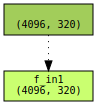

In [35]:
make_dot(f_in1, params={"y":y, "in1":in1, "in2":in2,"weight":weight, "f_in1":f_in1, "f_in2":f_in2, "f_weight":f_weight})

In [22]:
f_in1

tensor([[ 0.4196,  1.4742,  1.4455,  ...,  0.1817,  0.1963,  0.1579],
        [ 0.5642,  0.7783,  0.6315,  ...,  0.3729,  0.6434,  0.5800],
        [ 0.5101,  0.9792,  0.8448,  ..., -0.0714,  0.0506,  0.3608],
        ...,
        [ 0.3416,  1.0657,  0.6023,  ...,  0.1989,  0.1678,  0.1246],
        [ 1.7725,  1.0855,  0.8315,  ...,  0.2323,  0.9901,  0.4128],
        [ 1.9217,  0.6360,  0.9834,  ...,  0.6603,  0.5394,  0.7542]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [24]:
f_weight

tensor([[ 0.0078,  0.0100,  0.0005,  ...,  0.0329,  0.0214, -0.0286],
        [ 0.2418,  0.2786,  0.2790,  ...,  0.0006, -0.0356,  0.0444],
        [ 0.0516,  0.2150,  0.2629,  ..., -0.1135,  0.1353,  0.2274],
        ...,
        [ 0.2369,  0.1028,  0.1386,  ...,  0.0089,  0.0003,  0.0157],
        [ 0.0582,  0.0388,  0.1224,  ..., -0.0850, -0.1119, -0.1445],
        [ 0.0764,  0.3005,  0.2009,  ..., -0.0264,  0.0587,  0.0074]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [23]:
f_in2

tensor([[84.0002, 41.8671, 41.6277, 40.9111],
        [87.9291, 45.4150, 47.8192, 46.6050],
        [80.1224, 40.9374, 41.5159, 43.6381],
        ...,
        [82.8046, 39.6457, 42.5469, 42.2487],
        [78.1380, 40.3616, 42.4801, 43.2001],
        [78.1946, 46.2624, 45.9646, 48.4586]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [19]:
print(in1.grad)
print(in2.grad)
print(weight.grad)

tensor([[ 0.4196,  1.4742,  1.4455,  ...,  0.1817,  0.1963,  0.1579],
        [ 0.5642,  0.7783,  0.6315,  ...,  0.3729,  0.6434,  0.5800],
        [ 0.5101,  0.9792,  0.8448,  ..., -0.0714,  0.0506,  0.3608],
        ...,
        [ 0.3416,  1.0657,  0.6023,  ...,  0.1989,  0.1678,  0.1246],
        [ 1.7725,  1.0855,  0.8315,  ...,  0.2323,  0.9901,  0.4128],
        [ 1.9217,  0.6360,  0.9834,  ...,  0.6603,  0.5394,  0.7542]],
       device='cuda:0')
tensor([[84.0002, 41.8671, 41.6277, 40.9111],
        [87.9291, 45.4150, 47.8192, 46.6050],
        [80.1224, 40.9374, 41.5159, 43.6381],
        ...,
        [82.8046, 39.6457, 42.5469, 42.2487],
        [78.1380, 40.3616, 42.4801, 43.2001],
        [78.1946, 46.2624, 45.9646, 48.4586]], device='cuda:0')
tensor([[ 0.0078,  0.0100,  0.0005,  ...,  0.0329,  0.0214, -0.0286],
        [ 0.2418,  0.2786,  0.2790,  ...,  0.0006, -0.0356,  0.0444],
        [ 0.0516,  0.2150,  0.2629,  ..., -0.1135,  0.1353,  0.2274],
        ...,
        [ 0.

In [20]:
new_out = out_exp.grad.detach().clone()
new_out.requires_grad = True

In [21]:
in1_c_grad, in2_c_grad, w_c_grad = bwd_uvu(in1_c, in2_c,new_out , weight_c)

In [136]:
in1_c_grad.retain_grad()
in2_c_grad.retain_grad()
w_c_grad.retain_grad()
w_c_grad_gelu = torch.nn.functional.gelu(w_c_grad)
in1_c_grad_gelu = torch.nn.functional.gelu(in1_c_grad)
in2_c_grad_gelu = torch.nn.functional.gelu(in2_c_grad)

fake_loss = in1_c_grad_gelu.sum() + in2_c_grad_gelu.sum() + w_c_grad_gelu.sum()


In [137]:
# make_dot(fake_loss, params={"weight":weight_c, "in1":in1_c, "in2":in2_c, "new_out":new_out, }, show_attrs=True, show_saved=True)

In [138]:
fake_loss.backward()

In [139]:
upath_cnt = len(in1_idxing)-1
mem_dF_dO = torch.zeros_like(new_out)
mem_dL_dW =  torch.zeros_like(weight_c)
mem_dL_din1 =  torch.zeros_like(in1_c)
mem_dL_din2 = torch.zeros((batch_size, i_in2.dim * upath_cnt), device="cuda")
mem_debug =  torch.zeros_like(new_out)

In [140]:
sptp_bwd_bwd.sptp_linear_bwd_bwd_v2_shared(in1_c_grad.grad, in2_c_grad.grad, w_c_grad.grad, new_out, in1_c, in2_c, weight_c, 
                                           mem_dF_dO, mem_dL_dW, mem_dL_din1, mem_dL_din2, mem_debug,
                                           t_in1_idxing, t_in1_ival, t_in1_related_path_idx, 
                                           
                                           t_path_array1,t_path_array2,t_per_upath_fiber_start, t_path_weight,t_per_path_weight_pos, 
                                           t_per_upath_fiber_array,t_unique_cg_val, 
                                           upath_cnt, 1, l_max*2+1
                                           )

In [141]:
mem_dl_din2_summed = mem_dL_din2.reshape((batch_size, upath_cnt, i_in2.dim)).sum(dim=1)

In [142]:
compare(in1_c.grad, mem_dL_din1)
compare(in2_c.grad, mem_dl_din2_summed)
compare(weight_c.grad, mem_dL_dW)
compare(new_out.grad, mem_dF_dO)

All Good
All Good
All Good
All Good


In [53]:
dL_din1_result_list = {}
dL_din2_result_list = {}
dL_dw_result_list = []
dF_dOut_result_list = []
dF_uvuv_result_list = []

path_id = 0
for (l1, l2, l3, parity), (
            (mul_1, input_dim1, slice_1),
            (mul_2, input_dim2, slice_2),
            (output_mul, output_dim, _),
        ) in bwd_uvu.paths.items():
    w_slice = bwd_uvu.weight_slice[path_id]
    
    if slice_1.start not in dL_din1_result_list:
        dL_din1_result_list[slice_1.start] = []
    if slice_2.start not in dL_din2_result_list:
        dL_din2_result_list[slice_2.start] = []

    dF_in1 = in1_c_grad.grad[:, slice_1].reshape(-1, mul_1, input_dim1)
    dF_in2 = in2_c_grad.grad[:, slice_2].reshape(-1, mul_2, input_dim2)
    dF_dw = w_c_grad.grad[:, w_slice].reshape(-1, mul_1, mul_2)

    in1 = in1_c[:, slice_1].reshape(-1, mul_1, input_dim1)
    in2 = in2_c[:, slice_2].reshape(-1, mul_2, input_dim2)
    current_w = weight_c[:, w_slice].reshape(-1, mul_1, mul_2)
    cg = getattr(bwd_uvu, f"cg_{l1}_{l2}_{l3}")    
    
    dE_dOuter = bwd_uvu.dL_douter_result_list[path_id]
    dE_dOut = bwd_uvu.used_dL_dO_list[path_id]

    fwd_uvuv = bwd_uvu.uvuv_result_list[path_id]
    
    # dL_dw path
    dF_dOuter_1 = torch.einsum("zui,zvj -> zuvij", dF_in1, in2)
    dF_dOuter_2 = torch.einsum("zui,zvj -> zuvij", in1, dF_in2)
    dF_duvuv = torch.einsum("zuvij, ijk -> zuvk", dF_dOuter_1 + dF_dOuter_2, cg)
    
    dw = torch.einsum("zuvk, zuk -> zuv", dF_duvuv, dE_dOut)
    dL_dw_result_list.append(dw.reshape(batch_size, -1))

    # dL_din1, dL_din2 path (direct)
    dL_din1_1 = torch.einsum("zvj,zuvij -> zui", dF_in2, dE_dOuter)
    dL_din2_1 = torch.einsum("zui,zuvij -> zvj", dF_in1, dE_dOuter)

    # w-> uvuv ->in1,in2 (in-direct)
    dL_duvuv = torch.einsum("zuv, zuk->zuvk", dF_dw, dE_dOut)
    dL_douter = torch.einsum("zuvk, ijk -> zuvij", dL_duvuv, cg)

    dL_din1_2 = torch.einsum("zvj,zuvij -> zui", in2, dL_douter)
    dL_din2_2 = torch.einsum("zui,zuvij -> zvj", in1, dL_douter)

    # dF/dOut
    dF_dOut_1 = torch.einsum("zuvk,zuv -> zuk", dF_duvuv, current_w)
    dF_dOut_2 = torch.einsum("zuv, zuvk -> zuk", dF_dw, fwd_uvuv)
    dF_dOut_result_list.append((dF_dOut_1 + dF_dOut_2).reshape(4096,-1))

    dL_din1_result_list[slice_1.start].append((dL_din1_1 + dL_din1_2).reshape(batch_size,-1))
    dL_din2_result_list[slice_2.start].append((dL_din2_1 + dL_din2_2).reshape(batch_size,-1))

    dF_uvuv_result_list.append(dF_duvuv.reshape(batch_size,-1))

    path_id += 1


In [39]:
bwd_bwd_in1_grad = torch.cat([torch.stack(dL_din1_result_list[i], dim=0).sum(dim=0) for i in sorted(dL_din1_result_list.keys())],dim=-1)

In [40]:
bwd_bwd_in2_grad = torch.cat([torch.stack(dL_din2_result_list[i], dim=0).sum(dim=0) for i in sorted(dL_din2_result_list.keys())],dim=-1)

In [41]:
bwd_bwd_w_grad = torch.cat(dL_dw_result_list,dim=-1)

In [42]:
bwd_bwd_dF_dOut = torch.cat([dF_dOut_result_list[i] for i in bwd_uvu.sort2path],dim=-1)

In [43]:
compare(bwd_bwd_in1_grad, in1_c.grad)
compare(bwd_bwd_in2_grad, in2_c.grad)
compare(bwd_bwd_w_grad, weight_c.grad)
compare(bwd_bwd_dF_dOut, new_out.grad)

All Good
All Good
All Good
All Good


In [107]:
in1_c_grad.grad

tensor([[0.9445, 1.0634, 0.8020,  ..., 0.6121, 0.4798, 0.6113],
        [0.8888, 0.8327, 0.6529,  ..., 0.6616, 0.5009, 0.6517],
        [0.8042, 1.1100, 1.1256,  ..., 0.6438, 0.8135, 0.6496],
        ...,
        [0.8703, 0.6446, 0.8475,  ..., 0.7668, 0.8547, 0.7213],
        [0.8956, 0.6017, 0.6594,  ..., 0.5233, 0.4545, 0.6376],
        [0.8948, 1.0392, 0.9801,  ..., 0.6961, 0.7253, 0.7715]],
       device='cuda:0')

In [ ]:
path_id = 0
dL_duvuv = bwd_uvu.dL_duvuv_result_list[path_id]


In [99]:
bwd_uvu.uvuv_result_list[path_id].grad

tensor([[[[0.8439]],

         [[0.8260]],

         [[0.5262]],

         ...,

         [[0.5908]],

         [[0.6489]],

         [[0.6094]]],


        [[[0.8814]],

         [[0.9400]],

         [[0.9327]],

         ...,

         [[0.6381]],

         [[0.9279]],

         [[0.8302]]],


        [[[0.9277]],

         [[0.7558]],

         [[1.0640]],

         ...,

         [[0.7010]],

         [[0.9876]],

         [[0.7433]]],


        ...,


        [[[1.0055]],

         [[0.9282]],

         [[0.7122]],

         ...,

         [[0.5219]],

         [[0.6847]],

         [[0.6416]]],


        [[[0.5747]],

         [[0.5541]],

         [[0.5960]],

         ...,

         [[0.5846]],

         [[0.6137]],

         [[0.6138]]],


        [[[0.5968]],

         [[0.6644]],

         [[0.6918]],

         ...,

         [[0.6168]],

         [[0.6771]],

         [[0.7437]]]], device='cuda:0')

In [35]:
weight_c.grad[:,w_slice]

tensor([[0.4185, 0.5361, 0.0444,  ..., 0.6994, 0.4602, 0.5205],
        [1.0293, 1.0845, 1.0851,  ..., 1.0326, 1.1685, 1.5280],
        [0.4593, 1.0791, 1.2609,  ..., 0.5202, 0.6484, 0.8033],
        ...,
        [0.9831, 0.7440, 0.8077,  ..., 0.5734, 1.3865, 1.0628],
        [0.7272, 0.6967, 0.8282,  ..., 1.4566, 0.7146, 0.6859],
        [0.7638, 1.1111, 0.9568,  ..., 0.6994, 0.7759, 1.0551]],
       device='cuda:0')

In [37]:
torch.einsum("zuvk, zuk -> zuv", dL_duvuv, dL_out)

tensor([[[0.7874],
         [0.1344],
         [0.2190],
         ...,
         [0.4265],
         [0.0642],
         [0.3462]],

        [[0.1740],
         [0.5802],
         [0.5541],
         ...,
         [0.5123],
         [0.9454],
         [0.4302]],

        [[0.1658],
         [0.7772],
         [0.2972],
         ...,
         [0.3068],
         [0.2712],
         [0.5246]],

        ...,

        [[0.5565],
         [0.9619],
         [0.3850],
         ...,
         [0.1500],
         [0.9578],
         [0.4485]],

        [[0.9602],
         [0.7773],
         [0.3057],
         ...,
         [0.1741],
         [0.2345],
         [0.1896]],

        [[0.3221],
         [0.7318],
         [0.0559],
         ...,
         [0.8725],
         [0.6714],
         [0.9384]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [26]:
compare(in1_c_grad,in1.grad)

All Good


In [27]:
compare(in2_c_grad,in2.grad)

All Good


In [28]:
compare(w_c_grad,weight.grad)

All Good


In [137]:
path_cnt = 2
for (l1, l2, l3, parity), (
            (mul_1, input_dim1, slice_1),
            (mul_2, input_dim2, slice_2),
            (output_mul, output_dim, _),
        ) in bwd_uvu.paths.items():
    print(slice_1, slice_2)
    ss = bwd_uvu.dL_douter_result_list[path_cnt].reshape(batch_size, mul_1,mul_2,input_dim1, input_dim2)
    print(ss.shape)
    print(slice_2)
    print(torch.einsum("...uvij, ...vj -> ...ui", ss[0,] ,in2_c[0,slice_2].reshape(mul_2, input_dim2)))
    
    path_cnt +=1
    break

slice(0, 64, None) slice(0, 1, None)
torch.Size([4096, 64, 1, 1, 1])
slice(0, 1, None)
tensor([[0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.4503],
        [0.45

In [139]:
in1_c_grad[0]

tensor([ 0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,
         0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,
         0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,
         0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,
         0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,
         0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,
         0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,
         0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,  0.4503,
         0.4870,  0.5266,  0.1154,  0.4870,  0.5266,  0.1154,  0.4870,  0.5266,
         0.1154,  0.4870,  0.5266,  0.1154,  0.4870,  0.5266,  0.1154,  0.4870,
         0.5266,  0.1154,  0.4870,  0.5266,  0.1154,  0.4870,  0.5266,  0.1154,
         0.4870,  0.5266,  0.1154,  0.4870,  0.5266,  0.1154,  0.4870,  0.5266,
         0.1154,  0.4870,  0.5266,  0.11

In [115]:
in1.grad[0]

tensor([1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794, 1.5794,
        1.5794, 1.5794, 1.5794, 1.5794, 

In [102]:
path_idx = 4
dL_dO = torch.cat([x.reshape(batch_size,-1) for x in grad_uvu.w_result_list],dim=1)
W = grad_uvu.used_w_list[path_idx]


# dL_dO = grad_uvu.w_result_list[path_idx].grad
W = grad_uvu.used_w_list[path_idx]
O = grad_uvu.w_result_list[path_idx]
uvuv = grad_uvu.cg_result_list[path_idx]
uvuv_gen = (O / W).reshape(uvuv.shape)
cg = grad_uvu.used_cg_list[path_idx]

dL_duvuv = torch.einsum("zuk,zuv -> zuvk", dL_dO, W)
dL_dW = torch.einsum("zuk,zuvk -> zuv", dL_dO, uvuv_gen)
# only place with sparsity
dL_dOuter = torch.einsum("zuvk, ijk -> zuvij", dL_duvuv, cg)
# dL_dA = torch.einsum("zuvij,zvj -> zui", dL_dOuter, in2)
# dL_dB = torch.einsum("zuvij,zui -> zvj", dL_dOuter, in1)

RuntimeError: einsum(): the number of subscripts in the equation (3) does not match the number of dimensions (2) for operand 0 and no ellipsis was given

In [ ]:
compare(out[0], out_exp[0])

In [ ]:
print(out_exp[0])


In [ ]:
f_in1 = torch.autograd.grad(y, ori_r, create_graph=True)
# f_in1 = dd.forward(ori_r)
fake_f_truth = torch.rand_like(f_in1[0], requires_grad=False) - 0.5 
fake_f_truth *= (f_in1[0].detach().abs().mean() / fake_f_truth.abs().mean())

gated_f_in1 = torch.nn.functional.gelu(f_in1[0])
gated_f_in1.retain_grad()
f_loss = (gated_f_in1-fake_f_truth).sum()

# retain_grad_macro([out, y, *f_in1,f_loss])
f_loss.retain_grad()


f_loss.backward(retain_graph=True)

In [ ]:
# in1 = torch.rand(batch_size, i_in1.dim, device="cuda", requires_grad=True)
# in2 = torch.rand(batch_size, i_in2.dim, device="cuda", requires_grad=True)

# ## weight is tp.instruction order not out order
# weight = torch.rand(batch_size,tp.weight_numel, device="cuda", requires_grad=True)
# # weight = torch.ones(batch_size,tp.weight_numel, device="cuda", requires_grad=True)
# # grad_uvu = grad_uvu.cuda()

# in1_c = in1.clone().detach()
# in2_c = in2.clone().detach()
# weight_c = weight.clone().detach()

# in1_c.requires_grad =True
# in2_c.requires_grad =True
# weight_c.requires_grad =True

# tp = tp.cuda()


In [ ]:
out_c = tp(in1_c,in2_c,weight_c)
# out = grad_uvu(in1,in2,weight)
out_c.retain_grad()
y_c = out_c.sum()
y_c.retain_grad()
y_c.backward()
print(in2_c.grad)

In [ ]:
print(in1.grad)

In [ ]:
print(in2.grad)

In [ ]:
print(weight.grad)

In [ ]:
y.backward()

In [ ]:
print(in2.grad)

In [ ]:
make_dot(in1_grads, show_attrs=True, show_saved=True)

In [ ]:
in1_grads

In [ ]:
grads

In [ ]:
upath_cnt = len(in1_idxing)-1
mem_dl_din1 = torch.zeros_like(in1)
mem_dl_din2 = torch.zeros((batch_size, i_in2.dim * upath_cnt), device="cuda")
mem_dl_dw = torch.zeros_like(weight)
# mem_dl_do = torch.cat([x.grad.reshape(batch_size,-1) for x in grad_uvu.w_result_list],dim=1)
mem_dl_do = torch.ones((batch_size, i_out.dim), device="cuda")
mem_debug = torch.ones((batch_size, i_out.dim), device="cuda") * -1

In [ ]:
ops_out = torch.ops.sptp_linear.sptp_linear_fwd_v2_shared(
    in1_c,in2_c,weight_c, 
    t_in1_idxing, t_in1_ival, t_in1_related_path_idx, 
    t_path_array1,t_path_array2,t_per_upath_fiber_start, t_path_weight, t_per_path_weight_pos, 
    t_per_upath_fiber_array,t_unique_cg_val, 
    upath_cnt, 1, l_max, i_out.dim
)

In [ ]:
ops_y = ops_out.sum()
ops_y.backward()

In [ ]:
out

In [ ]:
ops_out

In [ ]:
compare(in1.grad,in1_c.grad)
compare(in2.grad,in2_c.grad)
compare(weight.grad,weight_c.grad)

In [ ]:
out_debug = torch.zeros_like(out)

In [ ]:
sptp_bwd.sptp_linear_fwd_v2_shared(in1,in2,weight, out_debug,
                            t_in1_idxing, t_in1_ival, t_in1_related_path_idx, t_path_array1,t_path_array2,t_per_upath_fiber_start, t_path_weight, t_per_path_weight_pos, t_per_upath_fiber_array,t_unique_cg_val, upath_cnt, 1, l_max*2+1
                            )

In [ ]:
compare(out[0],out_debug[0])

In [ ]:
sptp_bwd.sptp_linear_fwd_v2(in1,in2,weight, out_debug,
                            t_in1_idxing, t_in1_ival, t_in1_related_path_idx, t_path_array1,t_path_array2,t_per_upath_fiber_start, t_path_weight, t_per_path_weight_pos, t_per_upath_fiber_array,t_unique_cg_val, upath_cnt, 1,
                            )

In [ ]:
compare(out[0], out_debug[0])

In [ ]:
# out2 = grad_uvu(in1,in2,weight)

In [ ]:
# sum = 0
# for x in grad_uvu.w_result_list:
#     sum += x.reshape(batch_size,-1).shape[1]
# print(sum)

In [ ]:
sptp_bwd.sptp_linear_bwd_v1(in1,in2,weight, out.grad, mem_dl_din1, mem_dl_din2, mem_dl_dw, mem_debug,
                            t_in1_idxing, t_in1_ival , t_in1_related_path_idx, t_path_array1,t_path_array2,t_per_upath_fiber_start, t_path_weight, t_per_path_weight_pos, t_per_upath_fiber_array,t_unique_cg_val, upath_cnt, 1
                            )

In [ ]:
sptp_bwd.sptp_linear_bwd_v1_shared(in1,in2,weight, out.grad, mem_dl_din1, mem_dl_din2, mem_dl_dw, mem_debug,
                            t_in1_idxing, t_in1_ival, t_in1_related_path_idx, t_path_array1,t_path_array2,t_per_upath_fiber_start, t_path_weight, t_per_path_weight_pos, t_per_upath_fiber_array,t_unique_cg_val, upath_cnt, 2, l_max*2+1
                            )

In [ ]:
compare( in1.grad[0], mem_dl_din1[0])

In [ ]:
compare( weight.grad, mem_dl_dw)

In [ ]:
mem_dl_din2_summed = mem_dl_din2.reshape((batch_size, upath_cnt, i_in2.dim)).sum(dim=1)

In [ ]:
compare( in2.grad, mem_dl_din2_summed)

In [ ]:
### END OF FILE

In [ ]:
for idx, (i, j) in enumerate(zip(out[0], mem_debug[0])):
    print(idx, torch.isclose(i, j).item(), i.item(), j.item())

In [ ]:
for idx, (i, j) in enumerate(zip(weight.grad[0], mem_dl_dw[0])):
    print(idx, torch.isclose(i, j).item(), i.item(), j.item())

In [ ]:
t_in1_related_path_idx

In [ ]:
path_idx = 6
t_path_array1[path_idx]

In [ ]:
t_per_path_fiber_start[path_idx]

In [ ]:
t_fiber_array[14:20]

In [ ]:
t_unique_cg_val

In [ ]:
inst = tp.instructions[5]
print(inst)

In [ ]:
unique_cg_mat[f"{i_in1[inst.i_in1][1].l}_{i_in2[inst.i_in2][1].l}_{i_out[inst.i_out][1].l}"]

In [ ]:
for idx, (i, j) in enumerate(zip(out[3], mem_debug[3])):
    print(idx, torch.isclose(i, j).item(), i.item(), j.item())

In [ ]:
correct_dummy = torch.zeros(i_out.dim)

In [ ]:
for idx, i in enumerate(t_path_array1):
    dd = i.to(int).tolist()
    j_start = t_path_array2[idx][1]
    j_val = t_path_array2[idx][2]
    print(j_val.item())
    # correct_dummy[dd[0]:dd[1]] = t_fiber_array[t_per_path_fiber_start[idx][0]][1]
    fiber_y = t_fiber_array[t_per_path_fiber_start[idx][0]][1].item()
    correct_dummy[dd[0]:dd[1]] = in2[0][j_start.item()+fiber_y]
print(correct_dummy)

In [ ]:
for idx, x in enumerate(mem_debug[0]):
    print(idx, x.item())

In [ ]:
in1_idx = 3
path_start = in1_related_path_idx[in1_idx]
path_end = in1_related_path_idx[in1_idx+1]
for path_idx in range(path_start, path_end):
    for fiber_idx in range(per_path_fiber_start[path_idx][0], per_path_fiber_start[path_idx][1]):
        print(fiber_idx)

In [ ]:
path_array1

In [ ]:
weight.grad

In [ ]:
mem_dl_dw

In [ ]:
print(mem_debug)

In [ ]:
path_idx = 4
dL_dO = torch.cat([x.reshape(batch_size,-1) for x in grad_uvu.w_result_list],dim=1)
W = grad_uvu.used_w_list[path_idx]


# dL_dO = grad_uvu.w_result_list[path_idx].grad
W = grad_uvu.used_w_list[path_idx]
O = grad_uvu.w_result_list[path_idx]
uvuv = grad_uvu.cg_result_list[path_idx]
uvuv_gen = (O / W).reshape(uvuv.shape)
cg = grad_uvu.used_cg_list[path_idx]

dL_duvuv = torch.einsum("zuk,zuv -> zuvk", dL_dO, W)
dL_dW = torch.einsum("zuk,zuvk -> zuv", dL_dO, uvuv_gen)
# only place with sparsity
dL_dOuter = torch.einsum("zuvk, ijk -> zuvij", dL_duvuv, cg)
# dL_dA = torch.einsum("zuvij,zvj -> zui", dL_dOuter, in2)
# dL_dB = torch.einsum("zuvij,zui -> zvj", dL_dOuter, in1)

In [ ]:
weight.grad

In [ ]:
for idx, i in enumerate(mem_dl_dw[0]):
    print(idx, i.item())

In [ ]:
path_cnt

In [ ]:
mem_dl_din1

In [ ]:
mem_dl_din2

In [ ]:
in1.grad

In [ ]:
for idx, x in enumerate(mem_dl_din1[0]):
    print(idx, x.item())

In [ ]:
mem_dl_dw

In [ ]:
weight.grad

In [ ]:
def generate_edgepair (num_node, max_neighbour):
    edge_src = []
    edge_dst = []
    for i in range(num_node):
        num_neighbour = random.randint(0,max_neighbour)
        for j in range(num_neighbour):
            edge_dst.append(i)
            src_idx = i
            while(src_idx == i):
                src_idx = random.randint(0,num_node-1)
            edge_src.append(src_idx)
    return edge_src, edge_dst 

In [ ]:
total_node = 128
max_neighbour = 64
edge_src, edge_dst = generate_edgepair(total_node, max_neighbour)

In [ ]:
MAX_IR = 11
MAX_IN2 = 36
MAX_IN1_IR_CNT = 32
MAX_NUM_PATH = 512
MAX_U_FIBER_CNT = 5265
MAX_U_CG_VAL_CNT = 344

print(MAX_IN1_IR_CNT*12 + MAX_NUM_PATH*20 + MAX_U_FIBER_CNT*4 + MAX_U_CG_VAL_CNT*4)

In [ ]:
print(MAX_IR*5+MAX_IN2)

In [ ]:
tp.instructions

In [ ]:
grad_uvu.inv

In [ ]:
back_w = grad_uvu.used_w_list[0]
dl_dO = grad_uvu.w_result_list[0].grad

In [ ]:
# v = 1
# uvuv can easily retrievd by dividing it with path_weight * weight as v is 1

In [ ]:
path_idx = 4
dL_dO = grad_uvu.w_result_list[path_idx].grad
W = grad_uvu.used_w_list[path_idx]
O = grad_uvu.w_result_list[path_idx]
uvuv = grad_uvu.cg_result_list[path_idx]
uvuv_gen = (O / W).reshape(uvuv.shape)
cg = grad_uvu.used_cg_list[path_idx]

dL_duvuv = torch.einsum("zuk,zuv -> zuvk", dL_dO, W)
dL_dW = torch.einsum("zuk,zuvk -> zuv", dL_dO, uvuv_gen)
# only place with sparsity
dL_dOuter = torch.einsum("zuvk, ijk -> zuvij", dL_duvuv, cg)
# dL_dA = torch.einsum("zuvij,zvj -> zui", dL_dOuter, in2)
# dL_dB = torch.einsum("zuvij,zui -> zvj", dL_dOuter, in1)

In [ ]:
W.shape

In [ ]:
dL_duvuv = torch.einsum("zuk,zuv -> zuvk", dl_dO, back_w)

In [ ]:
dL_dw = torch.einsum("zuk,zuvk -> zuv", dl_dO, grad_uvu.cg_result_list[0])

In [ ]:
out[0]

In [ ]:
y = torch.rand(correct_out.shape)
loss = (correct_out-y)[0].sum()
loss.backward(retain_graph=True)

In [ ]:
total_fiber = 0
for key,val in unique_cg_mat.items():
    # print(key, val.count_nonzero().item())
    total_fiber += val.count_nonzero().item()
print(total_fiber)

In [ ]:
tp.weight_numel

In [ ]:
len(tp.instructions)

In [ ]:
i_in1

In [ ]:
unique_cg_lookup = list(set([x.item() for x in unique_cg]))


In [ ]:
len(unique_cg_lookup)

In [ ]:
5265 * 4 / 1024 

In [ ]:
cg_dummy.count_nonzero()

In [ ]:
39104 * (1+1+1) / 1024

In [ ]:
cg_dummy_kij = cg_dummy.permute(2,0,1)
cg_dummy_kij_flat = cg_dummy_kij.reshape(uvuv_i_out.dim, -1)
cg_kij_pos_tuple = cg_dummy_kij.nonzero(as_tuple=True)
cg_kij_pos_feed = cg_dummy_kij.nonzero().to(dtype=torch.int32).contiguous()
cg_kij_val_feed = cg_dummy_kij[cg_kij_pos_tuple]
per_out_fiber = cg_dummy_kij_flat.count_nonzero(dim=1)
unique_cg_lookup = list(set([x.item() for x in unique_cg]))

uni_cg_cnt = len(unique_cg_lookup)
out_size = uvuv_i_out.dim

In [ ]:
in1_occurance = torch.bincount(cg_kij_pos_tuple[1])

In [ ]:
in2_occurance = torch.bincount(cg_kij_pos_tuple[2])

In [ ]:
per_threadblock_data = {}
i_out_slice = i_out.slices()
for inst in tp.instructions:
    if inst.i_in1 not in per_threadblock_data.keys():
        per_threadblock_data[inst.i_in1] = {}
        per_threadblock_data[inst.i_in1]["out_slice"] = []
        per_threadblock_data[inst.i_in1][""] = 0
    per_threadblock_data[inst.i_in1]["out_slice"].append(i_out_slice[inst.i_out])

In [ ]:
cg_dummy_kij

In [ ]:
mac2nnz_ij = torch.bincount(cg_dummy_kij_flat.nonzero()[:,1])

In [ ]:
mac2nnz_ij.to(float).mean()

In [ ]:
nnz_cnt_for_each_path = []
for inst in tp.instructions:
    nnz_cnt_for_each_path.append((inst.i_in1, i_in1[inst.i_in1].dim//32, i_in2[inst.i_in2].dim, cg_dummy_kij_flat[i_out_slice[inst.i_out]].count_nonzero()//32))

In [ ]:
nnz_cnt_for_each_path

In [ ]:
in1_0_ij_nnz = torch.cat([cg_dummy_kij_flat[s] for s in per_threadblock_data[5]["out_slice"]], dim=0).nonzero()

In [ ]:
len(in1_0_ij_nnz[:,1].unique())

In [ ]:
for x in in1_0_ij_nnz:
    print(x[:,1].unique())

In [ ]:
in2_occurance

In [ ]:
in1_occurance

In [ ]:
per_in1_fiber = cg_dummy_kij_flat.count_nonzero(dim=1)


In [ ]:
in1 = torch.rand(batch_size, i_in1.dim)
in2 = torch.rand(batch_size, i_in2.dim)
out = torch.zeros((batch_size,uvuv_i_out.dim))

uni_w3j = torch.tensor(unique_cg_lookup)

if(tp.shared_weights):
    weight = torch.rand(tp.weight_numel)
else:
    # weight = torch.rand(batch_size,tp.weight_numel)
    weight = torch.ones(batch_size,tp.weight_numel)
    # weight[:,928:960] = 2

path_weight = torch.zeros(i_out.dim) 
for inst in tp.instructions:
    k = inst.i_out
    path_weight[i_out.slices()[k]] = inst.path_weight

In [ ]:
blk_u_in1_idx = []
blk_u_in2_idx = []

per_blk_u_in1_idx_range = []
per_blk_u_in2_idx_range = []
per_blk_fiber_start_range = []

per_fiber_local_idx = []
per_fiber_global_idx = []

max_u_in1_dim = 0
max_u_in2_dim = 0 
max_fiber_cnt = 0

pattern_len_array = []
stride_mul_array = []
rem_cum_idx_array = []
rem_cumval_array = []
fiber_cnt_array = []

step = 32
i = 0
while(i< uvuv_i_out.dim):
    local_k_idx = cg_dummy_kij[i:i+step].nonzero()[:,0]
    blk_in1_idx = cg_dummy_kij[i:i+step].nonzero()[:,1]
    blk_in2_idx = cg_dummy_kij[i:i+step].nonzero()[:,2]

    u_in1_list = blk_in1_idx.unique().tolist()
    u_in2_list = blk_in2_idx.unique().tolist()

    max_u_in1_dim = max(max_u_in1_dim, len(u_in1_list))
    max_u_in2_dim = max(max_u_in2_dim, len(u_in2_list))
    max_fiber_cnt = max(max_fiber_cnt, len(blk_in1_idx))

    blk_u_in1_idx.append(u_in1_list)
    blk_u_in2_idx.append(u_in2_list)

    per_blk_u_in1_idx_range.append(len(u_in1_list))
    per_blk_u_in2_idx_range.append(len(u_in2_list))

    per_blk_fiber_start_range.append(len(blk_in1_idx))

    local_in1_idx = [u_in1_list.index(x.item()) for x in blk_in1_idx]
    local_in2_idx = [u_in2_list.index(x.item()) for x in blk_in2_idx]

    for l_a,l_b,l_k,g_a,g_b in zip(local_in1_idx,local_in2_idx, local_k_idx,blk_in1_idx,blk_in2_idx):
        real_k = i + l_k
        cg_idx = unique_cg_lookup.index(cg_dummy_kij[real_k,g_a,g_b])

        per_fiber_local_idx.append(l_a)
        per_fiber_local_idx.append(l_b)
        per_fiber_local_idx.append(cg_idx)
        per_fiber_local_idx.append(l_k)

        per_fiber_global_idx.append(g_a)
        per_fiber_global_idx.append(g_b)
        per_fiber_global_idx.append(cg_idx)
        per_fiber_global_idx.append(real_k)


    pattern = per_out_fiber[i:i+step].tolist()
    pattern_length = 0
    if ([pattern[0]]*len(pattern) == pattern):
        pattern_length=1
    elif (list(itertools.chain.from_iterable(([pattern[0:3]]*len(pattern))))[0:len(pattern)] == pattern):
        pattern_length=3
    elif (list(itertools.chain.from_iterable(([pattern[0:5]]*len(pattern))))[0:len(pattern)] == pattern):
        pattern_length=5
    elif (list(itertools.chain.from_iterable(([pattern[0:7]]*len(pattern))))[0:len(pattern)] == pattern):
        pattern_length=7
    elif (list(itertools.chain.from_iterable(([pattern[0:9]]*len(pattern))))[0:len(pattern)] == pattern):
        pattern_length=9
    elif (list(itertools.chain.from_iterable(([pattern[0:11]]*len(pattern))))[0:len(pattern)] == pattern):
        pattern_length=11
    else:
        print("bad")

    unit_pattern = pattern[0:pattern_length]

    pattern_len_array.append(pattern_length)
    stride_mul_array.append(sum(unit_pattern))
    rem_cum_idx_array.append(pattern_length)

    rem_cumval_array.append(cumsum_list(unit_pattern, False))
    fiber_cnt_array.append(unit_pattern)

    i += step

rem_cum_idx_array = cumsum_list(rem_cum_idx_array,False)
per_blk_u_in1_idx_range  = cumsum_list(per_blk_u_in1_idx_range)
per_blk_u_in2_idx_range  = cumsum_list(per_blk_u_in2_idx_range)
per_blk_fiber_start_range = cumsum_list(per_blk_fiber_start_range)

rem_cumval_array = list(itertools.chain.from_iterable(rem_cumval_array))
fiber_cnt_array = list(itertools.chain.from_iterable(fiber_cnt_array))
blk_u_in1_idx = list(itertools.chain.from_iterable(blk_u_in1_idx))
blk_u_in2_idx = list(itertools.chain.from_iterable(blk_u_in2_idx))

per_fiber_local_idx = torch.tensor(per_fiber_local_idx).to(torch.uint8)
per_fiber_global_idx = torch.tensor(per_fiber_global_idx)

In [ ]:
max_u_in1_dim

In [ ]:
per_blk_w_idx = []
for w_idx, i in enumerate(uvuv_i_out):
    for j in range(i.ir.dim):
        per_blk_w_idx.append(w_idx)

In [ ]:
out_cuda = out.to(device="cuda")
main1_cuda = to_cuda_list(in1.T.contiguous(),in2.T.contiguous())
main2_cuda = to_cuda_list(uni_w3j,weight.T.contiguous(),path_weight)
meta_cuda = to_cuda_list(
                    per_blk_w_idx,
                    per_blk_u_in1_idx_range,
                    per_blk_u_in2_idx_range,
                    per_blk_fiber_start_range,
                    
                    blk_u_in1_idx,
                    blk_u_in2_idx,

                    pattern_len_array,
                    stride_mul_array,
                    rem_cum_idx_array,
                    rem_cumval_array,
                    fiber_cnt_array, 
                    
                    per_fiber_local_idx,
                    input_dtype=torch.uint16)
size_input = [max_u_in1_dim,max_u_in2_dim,max_fiber_cnt,uni_cg_cnt]
size_input = [int(x) for x in size_input]

In [ ]:
sptp.sptp_linear_v1(*main1_cuda, out_cuda, *main2_cuda,*meta_cuda,*size_input)

In [ ]:
out_cuda

In [ ]:
correct_out = tp(in1,in2,weight)

In [ ]:
correct_out

In [ ]:
index = 4033
torch.isclose(correct_out[index], out_cuda.cpu()[index]).all()
for a,b in zip(correct_out[index], out_cuda.cpu()[index]):
    print(torch.isclose(a,b),a,b)

In [ ]:
a_u_cnt = []
b_u_cnt = []
fiber_cnt = []
i_cnt = []
step = 32
i = 0
fiber_cnt_pattern = {}
while(i< uvuv_i_out.dim):
    u_in1 = cg_dummy_kij[i:i+step].nonzero()[:,1].unique()
    u_in2 = cg_dummy_kij[i:i+step].nonzero()[:,2].unique()


    l_a_u_cnt = (cg_dummy_kij[i:i+step].nonzero()[:,1].unique().numel())
    l_b_u_cnt = (cg_dummy_kij[i:i+step].nonzero()[:,2].unique().numel())
    l_fiber_cnt = (cg_dummy_kij[i:i+step].nonzero().shape[0])

    pattern = per_out_fiber[i:i+step].tolist()

    # print([pattern[0]]*len(pattern))
    

    # print(list(itertools.chain.from_iterable(([pattern[0:3]]*len(pattern))))[0:len(pattern)])
    # print(list(itertools.chain.from_iterable(([pattern[0:5]]*len(pattern))))[0:len(pattern)])
    
    if ([pattern[0]]*len(pattern) == pattern):
        pattern_tuple = (1, pattern[0])
    elif (list(itertools.chain.from_iterable(([pattern[0:3]]*len(pattern))))[0:len(pattern)] == pattern):
        pattern_tuple = (3, pattern[0:3])
    elif (list(itertools.chain.from_iterable(([pattern[0:5]]*len(pattern))))[0:len(pattern)] == pattern):
        pattern_tuple = (5, pattern[0:5])
    elif (list(itertools.chain.from_iterable(([pattern[0:7]]*len(pattern))))[0:len(pattern)] == pattern):
        pattern_tuple = (7, pattern[0:7])
    else:
        print("bad")
    

    if str(pattern_tuple) not in fiber_cnt_pattern:
        fiber_cnt_pattern[str(pattern_tuple)] = []
    fiber_cnt_pattern[str(pattern_tuple)].append(i//32)
    # # plt.scatter(cg_dummy_kij[i:i+step].nonzero()[:,0], cg_dummy_kij[i:i+32].nonzero()[:,1])
    # # plt.show()
    # # plt.close()
    # if(l_a_u_cnt > 60):
    #     l_a_u_cnt = (cg_dummy_kij[i:i+step//2].nonzero()[:,1].unique().numel())
    #     l_b_u_cnt = (cg_dummy_kij[i:i+step//2].nonzero()[:,2].unique().numel())
    #     l_fiber_cnt = (cg_dummy_kij[i:i+step//2].nonzero().shape[0])
    #     if(l_a_u_cnt > 60):
    #         l_a_u_cnt = (cg_dummy_kij[i:i+step//4].nonzero()[:,1].unique().numel())
    #         l_b_u_cnt = (cg_dummy_kij[i:i+step//4].nonzero()[:,2].unique().numel())
    #         l_fiber_cnt = (cg_dummy_kij[i:i+step//4].nonzero().shape[0])

    #         a_u_cnt.append(l_a_u_cnt)
    #         b_u_cnt.append(l_b_u_cnt)
    #         fiber_cnt.append(l_fiber_cnt)
    #         i_cnt.append(step//4)
    #         i += step//4
    #     else:
    #         a_u_cnt.append(l_a_u_cnt)
    #         b_u_cnt.append(l_b_u_cnt)
    #         fiber_cnt.append(l_fiber_cnt)
    #         i_cnt.append(step//2)
    #         i += step//2
    # else:
    a_u_cnt.append(l_a_u_cnt)
    b_u_cnt.append(l_b_u_cnt)
    fiber_cnt.append(l_fiber_cnt)
    i_cnt.append(step)
    i += step

In [ ]:
smem_size = []
for a, b, f, i in zip(a_u_cnt, b_u_cnt, fiber_cnt, i_cnt):
    smem_size.append((32 * (a+b+i+i) +f) * 4 )
    print(a,b,f,i)

In [ ]:
max(smem_size)